In [1]:
import nipype.algorithms.metrics as metr
import numpy as np
import matplotlib.pyplot as plt
from bids import BIDSLayout 

In [28]:
BIDS_dir = '/mnt/d/ADNI/ADNI_Hopf/Data/MCI/'
temp_dir = '/home/riccardo/ADNI_Hopf/Temp'

In [29]:
layout = BIDSLayout(BIDS_dir, validate = False, config = ['bids', 'derivatives'])
subjs = layout.get_subjects()

In [75]:

def get_masks(subj):

    my_masks = layout.get(subject = subj, datatype = 'anat', label = 'WMH', return_type='file')
    if my_masks != list():
        my_mask = my_masks[0]
        dns_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask.nii.gz'
        dns_improved_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask_improved.nii.gz'
    else:
        my_mask
    return my_mask, dns_mask, dns_improved_mask

def calculate_overlap(my_mask, dns_mask, dns_improved_mask):
    overlap = metr.Overlap()
    overlap.inputs.volume1 = my_mask
    overlap.inputs.volume2 = dns_mask
    my_vs_dns = overlap.run() 

    overlap.inputs.volume1 = my_mask
    overlap.inputs.volume2 = dns_improved_mask
    my_vs_dns_improved = overlap.run() 

    return my_vs_dns.outputs.dice, my_vs_dns_improved.outputs.dice

dice_my_vs_dns_list = []
dice_my_vs_dns_improved_list = []
subjs_with_wmh = []

my_mask_volume_list = []
for subj in subjs:
    my_masks = layout.get(subject = subj, datatype = 'anat', label = 'WMH', return_type='file')
    if my_masks != list():
        my_mask = my_masks[0]
        dns_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask.nii.gz'
        dns_improved_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask_improved.nii.gz'
        dice_my_vs_dns, dice_my_vs_dns_improved = calculate_overlap(my_mask, dns_mask, dns_improved_mask)
        dice_my_vs_dns_list.append(dice_my_vs_dns)
        dice_my_vs_dns_improved_list.append(dice_my_vs_dns_improved)
        subjs_with_wmh.append(subj)
        my_mask_volume_list.append(calculate_volume(my_mask))
    else:
        continue

In [31]:
import nibabel as nib
import nibabel.imagestats as nibstats
def get_masks(subj):
    dns_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask.nii.gz'
    dns_improved_mask = f'{temp_dir}/out/sub-{subj}_label-WMH_mask_improved.nii.gz'
    dns_mask_mni = f'{temp_dir}/out/sub-{subj}_space-MNI152NLin2009cAsym_label-WMH_mask.nii.gz'
    dns_improved_mask_mni = f'{temp_dir}/out/sub-{subj}_space-MNI2009cAsym_label-WMH_mask_improved.nii.gz'

    return dns_mask, dns_improved_mask, dns_mask_mni, dns_improved_mask_mni

def calculate_volume(img):
    wmh = nib.load(img)
    wmh_volume = round(nibstats.mask_volume(wmh),1)
    return wmh_volume

volume_dns_subj_space_list = []
volume_dns_improved_subj_space_list = []
volume_dns_mni_space_list = []
volume_dns_improved_mni_space_list = []

for subj in subjs:
    dns_mask, dns_improved_mask, dns_mask_mni, dns_improved_mask_mni = get_masks(subj)
    volume_dns_subj_space_list.append(calculate_volume(dns_mask))
    volume_dns_improved_subj_space_list.append(calculate_volume(dns_improved_mask))
    volume_dns_mni_space_list.append(calculate_volume(dns_mask_mni))
    volume_dns_improved_mni_space_list.append(calculate_volume(dns_improved_mask_mni))



In [32]:
volume_dns_subj_space_arr = np.array(volume_dns_subj_space_list)
volume_dns_improved_subj_space_arr = np.array(volume_dns_improved_subj_space_list)
volume_dns_mni_space_arr = np.array(volume_dns_mni_space_list)
volume_dns_improved_mni_space_arr = np.array(volume_dns_improved_mni_space_list)

In [72]:
volume_dns_improved_subj_space_arr - volume_dns_improved_mni_space_arr

array([  270.,   399., -1059., -3481.,   123.,  -171.,  -755.,  -654.,
        -480.,  -829.,    55.,   195.,    28.,   602.,  -952.,   232.,
         628.,    22.,  -655.])

In [34]:
def get_transformation(subj):
    """
    Returns the transformation matrix filename from the subject 'subj'. Note that although ANTS want the inverse transformation,
    according to https://neurostars.org/t/extracting-individual-transforms-from-composite-h5-files-fmriprep/2215, I tried and it's not
    what we want to do. So we just use the normal transform from T1 to MNI.

    Args:
        subj (str): the name of the subject originated from BIDSLayout.get_subjects()
    
    Returns:
        transformation (str): the filepath of the transformation from T1 to MNI
    
    """

    transformation = [f for f in layout.get(subject = subj, datatype = 'anat', extension = 'h5', return_type='file') if "from-T1w_to-MNI152NLin2009cAsym" in f]
    return transformation[0]

def get_T1(subj, space='subject'):
    """
    Returns the T1 file for the subject 'subj' in subject space.
    
    Args:
        subj (str): the name of the subject originated from BIDSLayout.get_subjects()
        space (str): one of ['subject', 'MNI2009']. The space in which you want the T1 image

    Returns:
        t1_filename (str): the filepath of the T1 image in subject space
        t1_mni2009_filename (str): the filepath of the T1 image in MNI2009cAsym space

    
    """
    spaces = ['subject', 'MNI2009']
    if space not in spaces:
        raise ValueError(f"Invalid space type. Expected one of: {spaces}")
    all_t1_filenames = layout.get(subject = subj, datatype = 'anat', desc = 'preproc', extension = 'nii.gz', return_type='file')
    t1_mni2009_filenames = layout.get(subject = subj, datatype = 'anat', desc = 'preproc', space = 'MNI152NLin2009cAsym', extension = 'nii.gz', return_type='file')
    t1_mni6_filenames = layout.get(subject = subj, datatype = 'anat', desc = 'preproc', space = 'MNI152NLin6Asym', extension = 'nii.gz', return_type='file')
    t1_filenames = [f for f in all_t1_filenames if f not in t1_mni2009_filenames + t1_mni6_filenames if 'FLAIR' not in f]
    return t1_filenames[0] if space == 'subject' else t1_mni2009_filenames[0]


from nipype.interfaces.ants import ApplyTransforms



for i, subj in enumerate(subjs):
    print(f'{i}/{len(subjs)}')
    dns_mask, dns_improved_mask, dns_mask_mni, dns_improved_mask_mni = get_masks(subj)
    t1_mni = get_T1(subj, 'MNI2009')
    transform = get_transformation(subj)
    at = ApplyTransforms()
    at.inputs.input_image = dns_mask
    at.inputs.reference_image = t1_mni
    at.inputs.output_image = f'{temp_dir}/out/sub-{subj}_label-WMH_transformed_from_subject_space.nii.gz'
    at.inputs.transforms = transform
    at.inputs.dimension = 3
    at.run()

    at.inputs.input_image = dns_improved_mask
    at.inputs.reference_image = t1_mni
    at.inputs.output_image = f'{temp_dir}/out/sub-{subj}_label-WMH_improved_transformed_from_subject_space.nii.gz'
    at.inputs.transforms = transform
    at.inputs.dimension = 3
    at.run()

0/19
1/19
2/19
3/19
4/19
5/19
6/19
7/19
8/19
9/19
10/19
11/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19


In [163]:
def get_masks(subj):
    dns_mask_mni = f'{temp_dir}/out/sub-{subj}_space-MNI152NLin2009cAsym_label-WMH_mask.nii.gz'
    dns_improved_mask_mni = f'{temp_dir}/out/sub-{subj}_space-MNI2009cAsym_label-WMH_mask_improved.nii.gz'
    dns_mask_from_subj_space = f'{temp_dir}/out/sub-{subj}_label-WMH_transformed_from_subject_space.nii.gz'
    dns_mask_improved_from_subj_space = f'{temp_dir}/out/sub-{subj}_label-WMH_improved_transformed_from_subject_space.nii.gz'


    return dns_mask_from_subj_space, dns_mask_improved_from_subj_space, dns_mask_mni, dns_improved_mask_mni

def calculate_volume(img):
    wmh = nib.load(img)
    wmh_volume = round(nibstats.mask_volume(wmh),1)
    return wmh_volume

volume_dns_mask_from_subj_space_list = []
volume_dns_mask_improved_from_subj_space_list = []
volume_dns_mni_space_list = []
volume_dns_improved_mni_space_list = []

for subj in subjs:
    dns_mask_from_subj_space, dns_mask_improved_from_subj_space, dns_mask_mni, dns_improved_mask_mni = get_masks(subj)
    dns_mask_from_subj_space = nimg.binarize_img(dns_mask_from_subj_space, 0.9)
    dns_mask_improved_from_subj_space = nimg.binarize_img(dns_mask_improved_from_subj_space, 0.9)

    volume_dns_mask_from_subj_space_list.append(round(nibstats.mask_volume(dns_mask_from_subj_space),1))
    volume_dns_mask_improved_from_subj_space_list.append(round(nibstats.mask_volume(dns_mask_improved_from_subj_space),1))

    volume_dns_mni_space_list.append(calculate_volume(dns_mask_mni))
    volume_dns_improved_mni_space_list.append(calculate_volume(dns_improved_mask_mni))

In [176]:
for subj in subjs[:2]:
    _, _, dns_mask_mni, _ = get_masks(subj) 
    bin_img = nimg.binarize_img(dns_mask_mni,  0.9)
    niplot.view_img(bin_img);

SyntaxError: invalid syntax (3256078615.py, line 3)

In [164]:
volume_dns_mask_improved_from_subj_space_arr = np.array(volume_dns_mask_improved_from_subj_space_list)
volume_dns_improved_mni_space_arr = np.array(volume_dns_improved_mni_space_list)
my_mask_volume_arr = np.array(my_mask_volume_list)

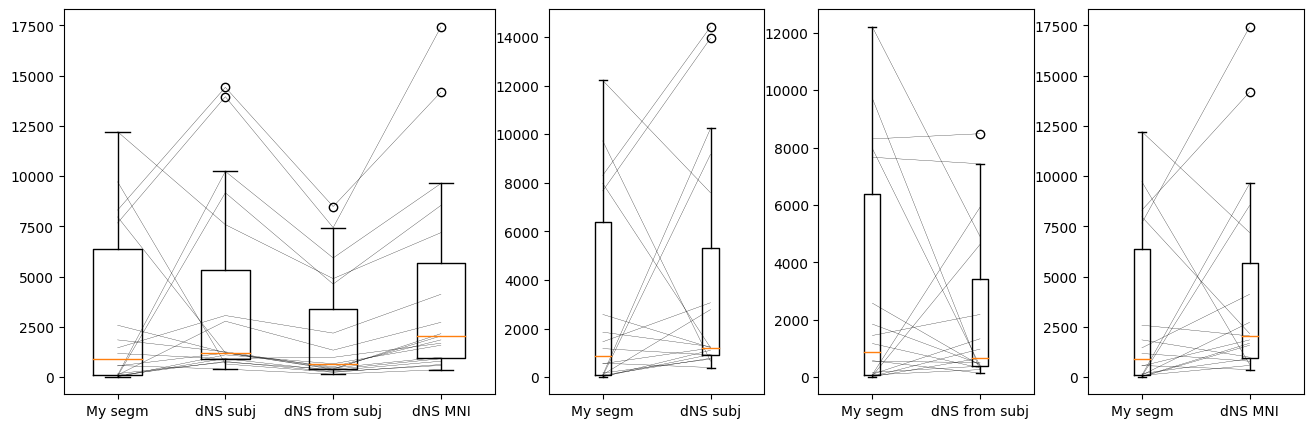

In [165]:
x_ticks = [1,2,3,4]
f, axs = plt.subplots(1, 4, width_ratios=[2, 1, 1, 1], figsize = (16, 5))
_ = axs[0].boxplot([my_mask_volume_arr, volume_dns_improved_subj_space_arr , volume_dns_mask_improved_from_subj_space_arr, volume_dns_improved_mni_space_arr]);
_ = axs[0].set_xticks([1,2,3,4],['My segm', 'dNS subj', 'dNS from subj', 'dNS MNI'])
for i in range(len(my_mask_volume_arr)):
   _ = axs[0].plot(x_ticks, [my_mask_volume_arr[i], volume_dns_improved_subj_space_arr[i], volume_dns_mask_improved_from_subj_space_arr[i], volume_dns_improved_mni_space_arr[i]], '-k', linewidth = 0.2);
# Plot comparison my vs dns improved in subject space   
_ = axs[1].boxplot([my_mask_volume_arr, volume_dns_improved_subj_space_arr ]);
_ = axs[1].set_xticks([1,2],['My segm', 'dNS subj'])
for i in range(len(my_mask_volume_arr)):
   _ = axs[1].plot([1,2], [my_mask_volume_arr[i], volume_dns_improved_subj_space_arr[i]], '-k', linewidth = 0.2);
# Plot comparison my vs dns improved in subject space   
_ = axs[2].boxplot([my_mask_volume_arr, volume_dns_mask_improved_from_subj_space_arr ]);
_ = axs[2].set_xticks([1,2],['My segm', 'dNS from subj'])
for i in range(len(my_mask_volume_arr)):
   _ = axs[2].plot([1,2], [my_mask_volume_arr[i], volume_dns_mask_improved_from_subj_space_arr[i]], '-k', linewidth = 0.2);

_ = axs[3].boxplot([my_mask_volume_arr, volume_dns_improved_mni_space_arr ]);
_ = axs[3].set_xticks([1,2],['My segm', 'dNS MNI'])
for i in range(len(my_mask_volume_arr)):
   _ = axs[3].plot([1,2], [my_mask_volume_arr[i], volume_dns_improved_mni_space_arr[i]], '-k', linewidth = 0.2);


plt.show()

In [159]:
x_ticks = [1,2,3]
f, axs = plt.subplots(1,1, figsize=(10, 5))
_ = axs[0].boxplot([volume_dns_improved_subj_space_arr , volume_dns_mask_improved_from_subj_space_arr, volume_dns_improved_mni_space_arr]);
_ = axs[0].set_xticks([1,2,3],['dNS subj', 'dNS from subj', 'dNS MNI'])
for i in range(len(volume_dns_improved_subj_space_arr)):
   _ = axs[0].plot(x_ticks, [volume_dns_improved_subj_space_arr[i], volume_dns_mask_improved_from_subj_space_arr[i], volume_dns_improved_mni_space_arr[i]], '-k', linewidth = 0.2);
plt.show()

array([0.00000000e+00, 1.60780061e-06, 2.66690502e-06, ...,
       9.99978045e-01, 9.99995881e-01, 1.00000000e+00])